
# --Imports


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
import pandas as pd
import sys
sys.path.append('../..')

# -- Pytorch tools
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

# -- Dataloading tools
import torchvision
from torchvision import datasets, models, transforms

# -- Spyrit packages
from spyrit.learning.model_Had_DCAN import * # models
from spyrit.misc.metrics import *  # psnr metrics
from spyrit.learning.nets import *  # traning, load, visualization...

# -- STL-10 (Loading the Compressed Data)

In [2]:
# Loading and normalizing STL10 :
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# The output of torchvision datasets are PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1]. Also
# RGB images transformed into grayscale images.

print("Loading STL-10 DATA")

img_size = 64  # Height-width dimension of the unknown image
batch_size = 256

data_root = Path('/home/licho/Documentos/Stage/Codes/STL10')
transform = transforms.Compose(
    [transforms.functional.to_grayscale,
     transforms.Resize((img_size, img_size)),
     transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5])])

trainset = \
    torchvision.datasets.STL10(root=data_root, split='train+unlabeled', download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False)

testset = \
    torchvision.datasets.STL10(root=data_root, split='test',download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

dataloaders = {'train': trainloader, 'val': testloader}
print("dataloaders are ready")

Loading STL-10 DATA
dataloaders are ready


# -- Precomputed data (Average and covariance matrix)

In [3]:
# -- Path to precomputed data (Average and covariance matrix -- for model)
precompute_root = Path('/home/licho/Documentos/Stage/Codes/Test')
Cov_had = np.load(precompute_root / "Cov_{}x{}.npy".format(img_size, img_size))
Mean_had = np.load(precompute_root / 'Average_{}x{}.npy'.format(img_size, img_size))
print("Average and covariance matrix loaded")

Average and covariance matrix loaded


# Un premièr approche mathématique

%%latex

On considère le problème de reconstruir une image $\mathbf{f} \in [0, 1]^{N\times 1}$ (dans l'echelle de gris et normalisé), en utilisant :

- $\mathbf{H}_{1}\in \left\lbrace0,1\right\rbrace^{M\times N}$, la base de motifs représentés avec le DMD (Ici $\mathbf{H}_{1}$ est choisit dans la base de Hadamard).


- $m(j)$ est une mesure, qui correspond au produit scalaire $\langle H_{1}(j),\mathbf{f}\rangle$, avec $H_{1}(j)$ la j-ème ligne de $\mathbf{H}_{1}$.


- $\mathbf{m} $  est le vecteur contenant les $M$ signaux mesurées, donc le plus simple modèle de formation d'image est donnée par 

$\mathbf{m} = \mathbf{H}_{1}\mathbf{f} \mbox{ , } \mathbf{m} \in \mathbf{R}^{M\times 1}$


L'objectif est de réduire le temps de acquisition, et on est donc restreint à reconstruir le paramètre $\mathbf{f}$ à partir d'un nombre $M$ de motifs, tels que $M<<N$. 
   
Lorsqu'on part de cette condition de sous-échantillonnage, le problème $\mathcal{P}$
   
\begin{equation}
\label{eq:pbIStock}
\mathcal{P}=\begin{cases}
\mbox{Trouver } \mathbf{f} \in [0, 1]^{N\times 1} \mbox{ t.q }  \\
\mathbf{m} = \mathbf{H}_{1}\mathbf{f} \mbox { , pour }\mathbf{H}_{1}\in \left\lbrace0,1\right\rbrace^{M\times N}\\
\mbox{Avec } M<<N
\end{cases}
\end{equation} 

Est donc un problème inverse mal posé.
                  
Cependant en pratique il existe differentes sources d'incertitude lesquelles ajoutent de bruit aux les mesures $m$ redant le probleme beaucoup plus complique. Du coup ce bruit est modelise comme un melange entre une variable aleatoire de poisson et une normal de la maniere suivante
    
\begin{equation}
m \sim K \mathcal{P}\left(N_{0} \mathbf{H}_{1}\mathbf{f} \right) + \mathcal{N}\left(\mu_{dark},\sigma^{2}_{dark} \right)
\end{equation}
    


# -- Acquisition parameters

In [4]:
print('Loading Acquisition parameters ( Covariance and Mean matrices) ')
# -- Compressed Reconstruction via CNN (CR = 1/8)
CR = 512  # Number of patterns ---> M = 1024 measures
N0 = 50  # noise level (light intensity) used in model training
N0_NVMS = 1  # Photon matrix correction level
N0_app = 50
sig = 0.5  # Noise variation

My_Noise_Variance_file = Path(precompute_root) / (
    'NVMS_{}_CR_{}_batch_size_{}.npy'.format(int(N0_NVMS), CR, batch_size))
Noise_Variance = np.load(My_Noise_Variance_file)
print('loaded : NVMS_{}_CR_{}_batch_size_{}.npy'.format(int(N0_NVMS), CR, batch_size))

My_Noise_Variance_approx_file = Path(precompute_root) / (
    'NVMS_{}_CR_{}_batch_size_{}.npy'.format(int(N0_app), CR, batch_size))
Noise_Variance_app = np.load(My_Noise_Variance_approx_file)
print('loaded : NVMS_{}_CR_{}_batch_size_{}.npy'.format(int(N0_app), CR, batch_size))

Loading Acquisition parameters ( Covariance and Mean matrices) 
loaded : NVMS_1_CR_512_batch_size_256.npy
loaded : NVMS_50_CR_512_batch_size_256.npy


# -- Hadamard patterns selection

On utilise la fonction **generate.py** qui appartient au package **Single-Pixel Acquisition Software (SPAS) - Python version**

**DMD_patterns** contiens la liste de toutes les coefficients de Hadamard, en incluant les valeurs negatives et positives de la base associée à l'espace tout entière (4096 pixels à calculer ---> 8192 coef en incluant les valeurs positives et negatives). 

Donc, cette matrice contient les vrais motif à mesurer pendant l'acquisition, c'est pour ca
que chacun a une dimension de 768x1024, en fait cette fonction donne exactement le motif à reproduire dans le DMD.

Mais en pratique on ne vais pas mesurer tous les motif, donc pour choisir ceux qui sont plus importants on utilise la fonction **generate_hadamard_order**, laquelle donne un vecteur avec les coefficients de Hadamard rangés d'accord a la  variabilité calcule d'après la base de données **STL10**, c'est-a-dire, pour une large base de données on calcule les coefficients de Hadamard pour chaque image et puis on range les coefficients selon leur variance, de cette manière on privilégie la mesure des coefficients dont le risque de tort est plus grand.

Dans ce cas on utilise $M = \frac{N^{2}}{8} = 512$ coefficients de Hadamard, ainsi que la matrice **'Cov_64x64.npy** calculé auparavant.

Ci-dessous on re-dimensionne la base de Hadamard $H$

# -- Model definition

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# --network architecture --> ['c0mp', 'comp','pinv', 'free'] --> [0, 1, 2, 3]
net_type = ['NET_c0mp', 'NET_comp', 'NET_pinv', 'NET_free']
net_arch = 0

############################
# -- Optimisation parameters
############################

# Number of training epochs
num_epochs = 60

# Regularisation Parameter
reg = 1e-7

# Learning Rate
lr = 1e-3

# Scheduler Step Size
step_size = 10

# Scheduler Decrease Rate
gamma = 0.5

# -- Loading Neural Network
model_root = Path('/home/licho/Documentos/Stage/Codes/Train_models')

# -- Available models classes : [compNet, noiCompNet, DenoiCompNet, DenoiCompNetSigma]

# -- This model computes the first layer solution with the teoterical variance

model0 = DenoiCompNetTheo(n=img_size, M=CR, Mean=Mean_had, Cov=Cov_had, NVMS=Noise_Variance, variant=net_arch, N0=N0, sig=sig)
model0 = model0.to(device)

# -- This model take the Diagonal approximation
model1 = DenoiCompNet(n=img_size, M=CR, Mean=Mean_had, Cov=Cov_had, NVMS=Noise_Variance, variant=net_arch, N0=N0, sig=sig)

suffix1 = '_N0_{}_sig_{}_Denoi_N_{}_M_{}_epo_{}_lr_{}_sss_{}_sdr_{}_bs_{}_reg_{}'.format(\
    N0, sig, img_size, CR, num_epochs, lr, step_size, gamma, batch_size, reg)

title2 = model_root / (net_type[net_arch] + suffix1)

load_net(title2, model1, device)

model1 = model1.to(device)

# --  This model take a First Order Taylor approximation with a Noise Variance Matrix Stabilization (NVMS)
model2 = DenoiCompNetNVMS(n=img_size, M=CR, Mean=Mean_had, Cov=Cov_had, NVMS=Noise_Variance, variant=net_arch, N0=N0, sig=sig)

suffix2 = '_N0_{}_sig_{}_DenoiNVMS_N_{}_M_{}_epo_{}_lr_{}_sss_{}_sdr_{}_bs_{}_reg_{}'.format(\
    N0, sig, img_size, CR, num_epochs, lr, step_size, gamma, batch_size, reg)

title2 = model_root / (net_type[net_arch] + suffix2)

load_net(title2, model2, device)
model2 = model2.to(device)

# --  This model take a First Order Taylor approximation with a
#     Noise Variance Matrix Stabilization calculated with a noise level of N0 
model3 = DenoiCompNetNVMS(n=img_size, M=CR, Mean=Mean_had, Cov=Cov_had, NVMS=Noise_Variance_app, variant=net_arch, N0=N0, sig=sig)
model3 = model3.to(device)

suffix3 = '_N0_{}_sig_{}_DenoiNVMS_50_N_{}_M_{}_epo_{}_lr_{}_sss_{}_sdr_{}_bs_{}_reg_{}'.format(\
    N0, sig, img_size, CR, num_epochs, lr, step_size, gamma, batch_size, reg)

title3 = model_root / (net_type[net_arch] + suffix3)

load_net(title3, model3, device)


Measurement to image domain: statistical completion (no mean)
loaded the precalculated matrix : NVMS
Varying N0 = 50 +/- 25
Denoised Measurements with theoretical inverse matrix
Measurement to image domain: statistical completion (no mean)
loaded the precalculated matrix : NVMS
Varying N0 = 50 +/- 25
Denoised Measurements
Model Loaded: /home/licho/Documentos/Stage/Codes/Train_models/NET_c0mp_N0_50_sig_0.5_Denoi_N_64_M_512_epo_60_lr_0.001_sss_10_sdr_0.5_bs_256_reg_1e-07
Measurement to image domain: statistical completion (no mean)
loaded the precalculated matrix : NVMS
Varying N0 = 50 +/- 25
Denoised Measurements with inverse matrix approximation (NVMS)
Model Loaded: /home/licho/Documentos/Stage/Codes/Train_models/NET_c0mp_N0_50_sig_0.5_DenoiNVMS_N_64_M_512_epo_60_lr_0.001_sss_10_sdr_0.5_bs_256_reg_1e-07
Measurement to image domain: statistical completion (no mean)
loaded the precalculated matrix : NVMS
Varying N0 = 50 +/- 25
Denoised Measurements with inverse matrix approximation (NVMS

# -- We fix an image batch for the visual test

In [6]:
# this is a ndarray  of size : (batch_size, 1, 64, 64) containing the STL-10 images
inputs, classes = next(iter(dataloaders['val']))

# -- Displaying the results

In [7]:
## -- Measurement adquisition

In [8]:
# Once all the networks have been loaded, we apply those networks on the loaded Compressed Data.
# Attention to general model configuration : 'Network architecture' +  'Model class' +  ' Reconstructor method'

m0 = model0.forward_acquire(inputs.to(device), batch_size, 1, img_size, img_size)
var_theo = model0.forward_theoretical_variance(inputs.to(device), batch_size, 1, img_size, img_size)

m1 = model1.forward_acquire(inputs.to(device), batch_size, 1, img_size, img_size)
m2 = model2.forward_acquire(inputs.to(device), batch_size, 1, img_size, img_size)
m3 = model3.forward_acquire(inputs.to(device), batch_size, 1, img_size, img_size)

# -- Methods without post-process

Once all the networks have been loaded, we apply those networks on the loaded Compressed Data.
Attention to general model configuration : 'Network architecture' +  'Model class' +  ' Reconstructor method'

## -- Model 0 : Denoising stage is performed and theoretical variance is taken 

\begin{equation}
\Sigma_{1}(\Sigma_{1} + \Sigma^{Theo}_{\alpha})^{-1} \mbox{ with } \Sigma^{Theo}_{\alpha} = \frac{(H^{+} + H^{-} )f}{\alpha}
\end{equation}

In [9]:
f0 = model0.forward_theoretical_maptoimage(m0, var_theo, batch_size, 1, img_size, img_size)

## --  Model 1 : Denoising stage is performed and the diagonal approximation is taken (Paper approach)

\begin{equation}
\Sigma_{1}(\Sigma_{1} + \Sigma_{\alpha})^{-1} \simeq D_{1}(D_{1} + \Sigma_{\alpha})^{-1}
\end{equation}


In [10]:
f1 = model1.forward_maptoimage(m1, batch_size, 1, img_size, img_size)

## -- Model 2 : Denoising stage and a first order Taylor matrix approximation with NVMS are performed

\begin{equation}
\Sigma_{1}(\Sigma_{1} + \Sigma_{\alpha})^{-1} \simeq \Sigma_{1}(\Sigma_{1} + \widetilde{\Sigma}_{\alpha})^{-1} -  \Sigma_{1}(\Sigma_{1} + \widetilde{\Sigma}_{\alpha})^{-1} ( \Sigma_{\alpha} - \widetilde{\Sigma}_{\alpha}) (\Sigma_{1} + \widetilde{\Sigma}_{\alpha})^{-1}
\end{equation}

Where

$\widetilde{\Sigma}_{\alpha} = \frac{1}{S} \displaystyle\sum^{S}_{i=1}\left(m^{+,i}_{\alpha} + m^{-,i}_{\alpha}\right) $ for $S = \mbox{Batch_size}$ 

In [11]:
f2 = model2.forward_maptoimage(m2, batch_size, 1, img_size, img_size)

## -- Model 3 : Denoising stage and a first order Taylor matrix approximation with NVMS are performed (NVMS is precalculated with N0 = 50 )

\begin{equation}
\Sigma_{1}(\Sigma_{1} + \Sigma_{\alpha})^{-1} \simeq \Sigma_{1}(\Sigma_{1} + \widetilde{\Sigma}_{\alpha})^{-1} -  \Sigma_{1}(\Sigma_{1} + \widetilde{\Sigma}_{\alpha})^{-1} ( \Sigma_{\alpha} - \widetilde{\Sigma}_{\alpha}) (\Sigma_{1} + \widetilde{\Sigma}_{\alpha})^{-1}
\end{equation}

Where

$\widetilde{\Sigma}_{\alpha} = \frac{1}{S\alpha^{2}} \displaystyle\sum^{S}_{i=1}\left(m^{+,i}_{\alpha} + m^{-,i}_{\alpha}\right) $ for $S = \mbox{Batch_size}$ et $\alpha = 50$ 

In [12]:
f3 = model3.forward_maptoimage(m3, batch_size, 1, img_size, img_size)

## -- Network models :

In [13]:
## -- Model 4 : Denoising stage is performed and the diagonal approximation is taken (Paper approach)
NETf1 = model1.forward_postprocess(f1, batch_size, 1, img_size, img_size)

## -- Model 5 : Denoising stage and a first order Taylor matrix approximation with NVMS are performed
NETf2 = model2.forward_postprocess(f2, batch_size, 1, img_size, img_size)

## -- Model 6 : Denoising stage and a first order Taylor matrix approximation with NVMS50 are performed
NETf3 = model3.forward_postprocess(f3, batch_size, 1, img_size, img_size)

# -- Displaying the results -- Models without precomputed noise

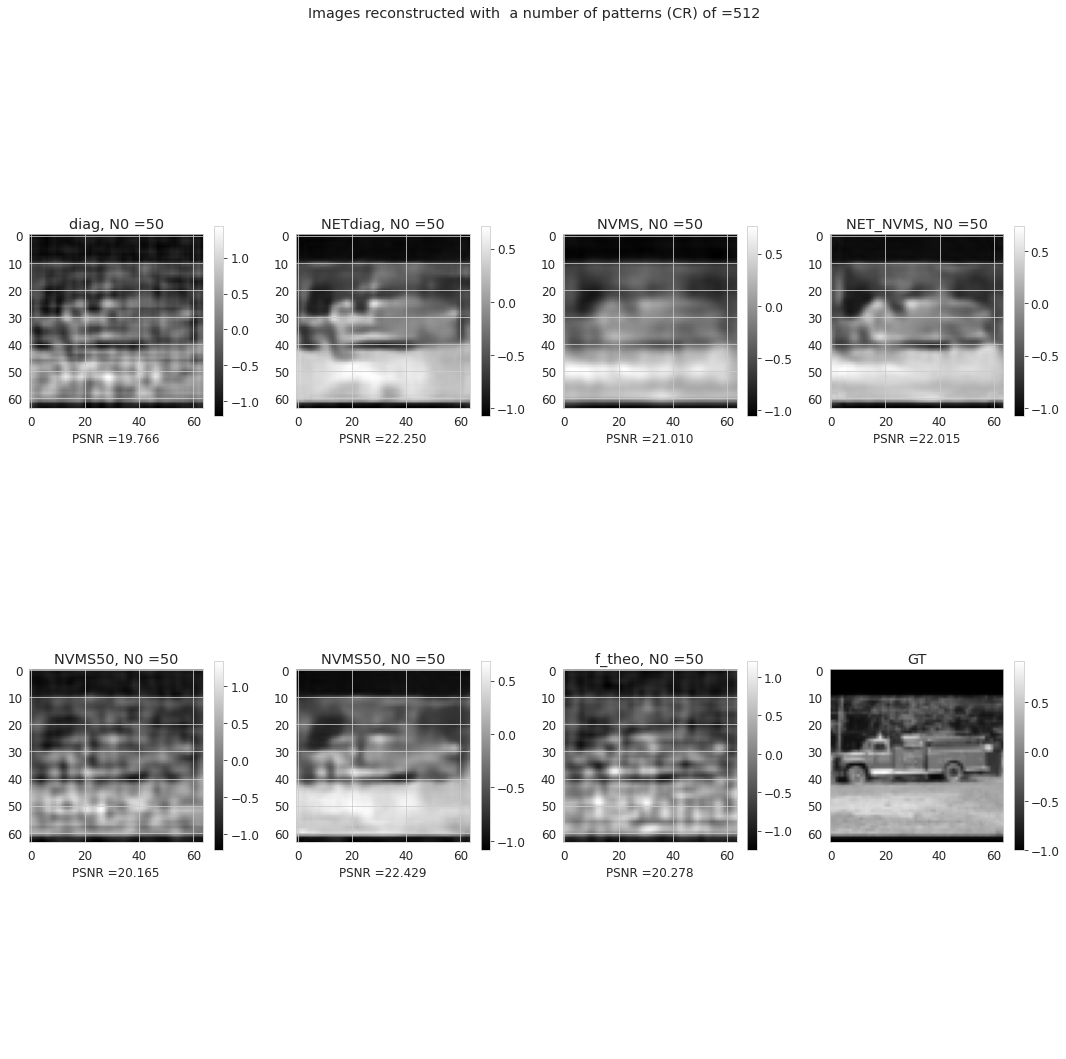

In [22]:
# numpy ground-true : We select an image for visual test
h = 45
Gt = inputs[h, 0, :, :].numpy()

fig, axes = plt.subplots(figsize=(15, 15))
fig.suptitle("Images reconstructed with  a number of patterns (CR) of =%i" % CR)
plt.axis('off')
rows = 2
cols = 4

f_diag = f1[h, 0, :, :].cpu().detach().numpy()
fig.add_subplot(rows, cols, 1)
plt.title("diag, N0 =%i" % N0)
plt.xlabel("PSNR =%.3f" % psnr(Gt, f_diag))
fig1 = plt.imshow(f_diag, cmap='gray')
plt.colorbar(fig1, shrink=0.32)

f_NETdiag = NETf1[h, 0, :, :].cpu().detach().numpy()
fig.add_subplot(rows, cols, 2)
plt.title("NETdiag, N0 =%i" % N0)
plt.xlabel("PSNR =%.3f" % psnr(Gt, f_NETdiag))
fig2 = plt.imshow(f_NETdiag, cmap='gray')
plt.colorbar(fig2, shrink=0.32)

f_NVMS = f2[h, 0, :, :].cpu().detach().numpy()
fig.add_subplot(rows, cols, 3)
plt.title("NVMS, N0 =%i" % N0)
plt.xlabel("PSNR =%.3f" % psnr(Gt, f_NVMS))
fig3 = plt.imshow(f_NVMS, cmap='gray')
plt.colorbar(fig3, shrink=0.32)

f_NETNVMS = NETf2[h, 0, :, :].cpu().detach().numpy()
fig.add_subplot(rows,cols,4)
plt.title("NET_NVMS, N0 =%i" % N0)
plt.xlabel("PSNR =%.3f" % psnr(Gt, f_NETNVMS))
fig4 = plt.imshow(f_NETNVMS, cmap='gray')
plt.colorbar(fig4, shrink=0.32)

f_NVMS50 = f3[h, 0, :, :].cpu().detach().numpy()
fig.add_subplot(rows, cols, 5)
plt.title("NVMS50, N0 =%i" % N0)
plt.xlabel("PSNR =%.3f" % psnr(Gt, f_NVMS50))
fig5 = plt.imshow(f_NVMS50, cmap='gray')
plt.colorbar(fig5, shrink=0.32)

f_NETNVMS50 = NETf3[h, 0, :, :].cpu().detach().numpy()
fig.add_subplot(rows, cols, 6)
plt.title("NVMS50, N0 =%i" % N0)
plt.xlabel("PSNR =%.3f" % psnr(Gt, f_NETNVMS50))
fig6 = plt.imshow(f_NETNVMS50, cmap='gray')
plt.colorbar(fig6, shrink=0.32)

f_theo = f0[h, 0, :, :].cpu().detach().numpy()
fig.add_subplot(rows,cols,7)
plt.title("f_theo, N0 =%i" % N0)
plt.xlabel("PSNR =%.3f" % psnr(Gt, f_theo))
fig7 = plt.imshow(f_theo, cmap='gray')
plt.colorbar(fig7, shrink=0.32)

fig.add_subplot(rows, cols, 8)
plt.title("GT")
fig8 = plt.imshow(Gt, cmap='gray')
plt.colorbar(fig8, shrink=0.32)

fig.tight_layout()
plt.grid(False)
plt.show()

# -- PSNR test on the validation set

In [15]:
psnr_theo = dataset_psnr_theo(dataloaders['val'], model0, device)
print_mean_std(psnr_theo, 'theo')
# print_mean_std(psnr_NETtheo, 'NETtheo')

psnr_NETdiag, psnr_diag = dataset_psnr(dataloaders['val'], model1, device)
print_mean_std(psnr_diag, 'diag')
print_mean_std(psnr_NETdiag, 'NETdiag')

psnr_NETNVMS, psnr_NVMS = dataset_psnr(dataloaders['val'], model2, device)
print_mean_std(psnr_NVMS, 'NVMS')
print_mean_std(psnr_NETNVMS, 'NETNVMS')

psnr_NETNVMS50, psnr_NVMS50 = dataset_psnr(dataloaders['val'], model3, device)
print_mean_std(psnr_NVMS50, 'NVMS50')
print_mean_std(psnr_NETNVMS50, 'NETNVMS50')


theopsnr = 19.170275392152778 +/- 1.4637062715580136
diagpsnr = 18.52765542734213 +/- 1.5553389795668042
NETdiagpsnr = 21.539005378341027 +/- 1.5928569984450738
NVMSpsnr = 20.356891104781056 +/- 1.5867398902292598
NETNVMSpsnr = 21.35339347610634 +/- 1.6258541813024052
NVMS50psnr = 19.26982476987238 +/- 1.454911326246344
NETNVMS50psnr = 21.573727236324178 +/- 1.599854188540789


## --Boxplot

Text(0, 0.5, 'PSNR')

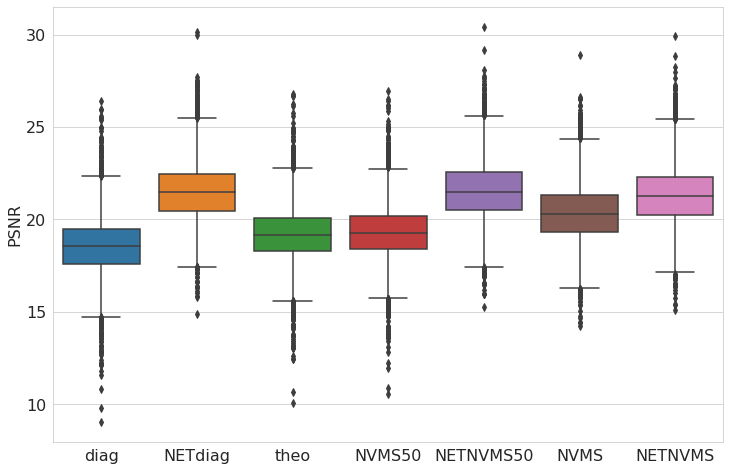

In [16]:
plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.figsize'] = [12, 8]
plt.figure()
sns.set_style("whitegrid")
axes = sns.boxplot(data=pd.DataFrame([psnr_diag, psnr_NETdiag, psnr_theo, psnr_NVMS50, psnr_NETNVMS50, psnr_NVMS, psnr_NETNVMS]).T)
axes.set_xticklabels(['diag', 'NETdiag', 'theo', 'NVMS50', 'NETNVMS50', 'NVMS', 'NETNVMS']);
axes.set_ylabel('PSNR')

# Load training history

In [17]:
train_path1 = model_root/('TRAIN_c0mp'+suffix1+'.pkl')
train_NETdiag = read_param(train_path1)

train_path2 = model_root/('TRAIN_c0mp'+suffix2+'.pkl')
train_NETNVMS = read_param(train_path2)

train_path3 = model_root/('TRAIN_c0mp'+suffix3+'.pkl')
train_NETNVMS50 = read_param(train_path3)

plt.rcParams.update({'font.size': 12})

# Training Plot

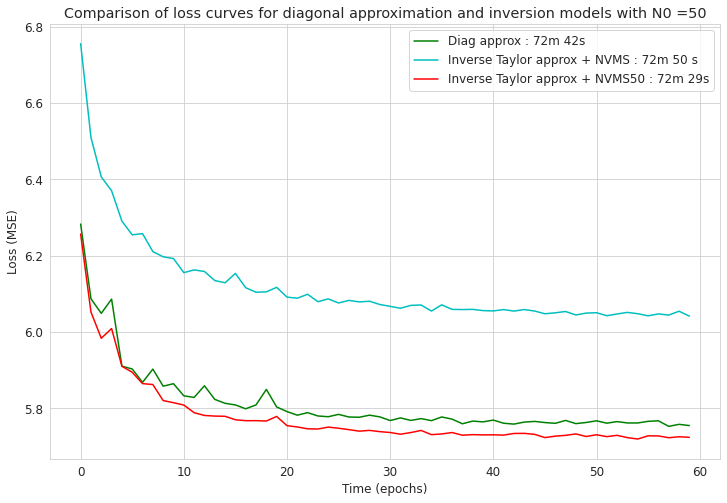

In [18]:
fig1, ax = plt.subplots(figsize=(12,8))
plt.title('Comparison of loss curves for diagonal approximation and inversion models with N0 =%i' % N0)
ax.set_xlabel('Time (epochs)')
ax.set_ylabel('Loss (MSE)')
ax.plot(train_NETdiag.val_loss,'g', linewidth=1.5)
ax.plot(train_NETNVMS.val_loss,'c', linewidth=1.5)
ax.plot(train_NETNVMS50.val_loss,'r', linewidth=1.5)
ax.grid(which='minor', linestyle=':', linewidth=0.5, color='black')
plt.grid(True)
ax.legend(('Diag approx : 72m 42s ', 'Inverse Taylor approx + NVMS : 72m 50 s', 'Inverse Taylor approx + NVMS50 : 72m 29s' ),  loc='upper right')